In [6]:
library(tidyverse) #The mother of all analysis packages
library(tidyverse) #The mother of all analysis packages
library(rvest) #Scraping web pages
library(httr) #Lets us use requests for data from APIs
library(tidyr) #Functions to help keep our data tidy
library(magrittr) #Piping
library(purrr) #Useful functions for general df wrangling, especially for functions
library(glue) #Gives us useful functions for strings
library(stringr) #More useful functions for strings
library(polite) #For web scraping
library(xml2) #Allows us to work with xml files obtained through scraping
library(GGally) #Produces handy scatterplot matrix with correlations between columns in a dataframe
library(leaps) #Contains regsubsets() to help us select predictors for our model
library(car) #Contains AIC, which we're using for model analysis
library("jsonlite") #Gives functions to help us work with json from API request content
library(plotly) #Allows us to develop interactive graphs - compatible with ggplot2
library(ggthemr) #Extra nice-looking themes for ggplot2 graphs
library(tm) #Contains the function which allows us to remove numbers from a string
ggthemr('dust') #Sets the themes for our plots


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘plotly’


The following object is masked from ‘package:httr’:

    config


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: NLP


Attaching

In [7]:
options(repr.plot.width=25, repr.plot.height=10)

In [8]:
oecdlabour_df <- read.csv(
    'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HRWKD.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en')
#Reads in csv directly from OECD website
glimpse(oecdlabour_df) #the glimpse function allows us to have a peek at what the dataset will look like

Rows: 1,803
Columns: 8
$ LOCATION   <chr> "AUS", "AUS", "AUS", "AUS", "AUS", "AUS", "AUS", "AUS", "AU…
$ INDICATOR  <chr> "HRWKD", "HRWKD", "HRWKD", "HRWKD", "HRWKD", "HRWKD", "HRWK…
$ SUBJECT    <chr> "TOT", "TOT", "TOT", "TOT", "TOT", "TOT", "TOT", "TOT", "TO…
$ MEASURE    <chr> "HR_WKD", "HR_WKD", "HR_WKD", "HR_WKD", "HR_WKD", "HR_WKD",…
$ FREQUENCY  <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A",…
$ TIME       <int> 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,…
$ Value      <dbl> 1876.000, 1877.000, 1889.000, 1885.000, 1875.000, 1853.000,…
$ Flag.Codes <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…


In [9]:
oecdlabour_df <- (oecdlabour_df %>% select(LOCATION, TIME, Value))
oecdlabour_df = tibble(Countries = oecdlabour_df$`LOCATION`, Years = oecdlabour_df$`TIME`, Hours = oecdlabour_df$`Value`)

In [10]:
codes_url = 'https://www.worlddata.info/countrycodes.php'
code_page = read_html(codes_url) #Reads in the html body from the webpage
code_page %>% glimpse() #Double check that the body has read in correctly (we look at the classes of the objects)

countries_url = 'http://www.energybc.ca/cache/nuclear/nuclear2/www.oecd.org/document/1/0,2340,en_2649_201185_1889402_1_1_1_1,00.html'
countries_page = read_html(countries_url) #Reads in the html body from the webpage
countries_page %>% glimpse() #Double check that the body has read in correctly (we look at the classes of the objects)
oecd_countries = countries_page %>% html_nodes(xpath = '//*[@class="more"]') %>% html_text() #Uses the xpath selector corresponding to the codes in order to get the correct items
oecd_countries = oecd_countries[1:length(oecd_countries)-1] #The last row was irrelevant - this line removes it

List of 2
 $ node:<externalptr> 
 $ doc :<externalptr> 
 - attr(*, "class")= chr [1:2] "xml_document" "xml_node"
List of 2
 $ node:<externalptr> 
 $ doc :<externalptr> 
 - attr(*, "class")= chr [1:2] "xml_document" "xml_node"


In [11]:
#In the data that we read in, South Korea was called Korea - which is different to what it's called in the OECD dataset,
#thus we need to change them in order to appropriately merge this with the other scraped OECD data
for (i in seq.int(1, length(oecd_countries))){
    if (oecd_countries[i] == 'Korea'){ #For each country in the list of OECD countries, if the country is 'Korea' change its
                                        #value to 'South Korea'
        oecd_countries[i] = 'South Korea'
    }
}

In [12]:
all_codes = code_page %>% html_nodes(xpath = '//*[@class="std100 hover"]') %>% html_text()
#Using xpath selector to extract the desired text from page of country codes
country_codes = unlist(strsplit(all_codes, "[.]"))
#After extracting using the xpath selector, the codes had "." in between them, this function removes these and returns a list
#We then use "unlist()" to turn it into an array

In [13]:
output = array()
countries = array()
codes = array()
#Initialising variables
for (country_data in country_codes){
    country_data = substring(country_data, 1, nchar(country_data)-8)
    country_data = substring(country_data, 3, nchar(country_data))
    country_data = removeNumbers(country_data)
    code = substring(country_data, nchar(country_data)-2, nchar(country_data)) 
    country = substring(country_data, 1, nchar(country_data)-3)
    country = substring(country, 1, nchar(country)-2)
    countries = countries %>% append(country)
    codes = codes %>% append(code)
}
#Essentially, this data was really messy to read in (there were multiple different values for each country, such as website suffixes and mobile codes - all of different lengths)
#so I applied a few calls to the substring function to isolate the country name and the code we were interested in (the 3 letter one) from the other unwanted data.
#The for loop adds the countries to the countries array and codes to the codes array

#Note we are including non-OECD countries here - which will get weeded out when comparing this array to the array of OECD countries

In [15]:
#The following function which returns a list which maps a country to a code, thus when converting countries into codes can be used like:
#country = list_for_conversion[code], thus we can convert the codes into countries to be used as the primary key (along with year of observation) when joining the table
#containing labour hours to the main table containing all other data.
countriesAndCodes = function(countries, codes) {
    output_countries = array() #initializes countries array
    output_codes = array() #initializes codes array
    for (i in seq.int(1, length(countries))){ #Both arrays are the same length
        if (countries[i] %in% oecd_countries){ #Checks if country is in the OECD
            output_countries = output_countries %>% append(countries[i]) #Appends the country to the countries array
            output_codes = output_codes %>% append(codes[i]) #Appends the code to the codes array
        }
    }
    output_list = as.list(output_countries[2:length(output_countries)]) #Creates the list, with the countries as values
    names(output_list) = as.list(output_codes[2:length(output_codes)]) #Sets codes to be the keys to the countries
    return(output_list) #Returns the list
}

list_for_conversions = countriesAndCodes(countries, codes) #Applies the function

In [16]:
table_codes = oecdlabour_df$`Countries` #Gets the codes to be converted into countries

#Looping through codes to convert them into countries - which will then occupy the countries column in place of the codes
converted_countries = array() #Intialises array
for (i in seq.int(1, length(table_codes))){ #Starts loop to terminate at the end of the codes list
    converted_countries = converted_countries %>% append(as.character(list_for_conversions[table_codes[i]])) #Uses the list we created with
    #the previous function --> country = list_for_conversions[code] and then adds the country to our array
}

oecdlabour_df$`Countries` = converted_countries[2:length(converted_countries)] #Changes the Countries column from the codes to the countries

filtered_labour <- oecdlabour_df %>% filter(`Countries` == 'New Zealand' | `Countries` == 'Netherlands' |
                                              `Countries` == 'United States' | `Countries` == 'South Korea')
#Filters out all countries that are not countries of interest
filtered_labour
#Double checking our dataframe


Countries,Years,Hours
<chr>,<int>,<dbl>
South Korea,2008,2228
South Korea,2009,2174
South Korea,2010,2163
South Korea,2011,2136
South Korea,2012,2119
South Korea,2013,2106
South Korea,2014,2076
South Korea,2015,2083
South Korea,2016,2068


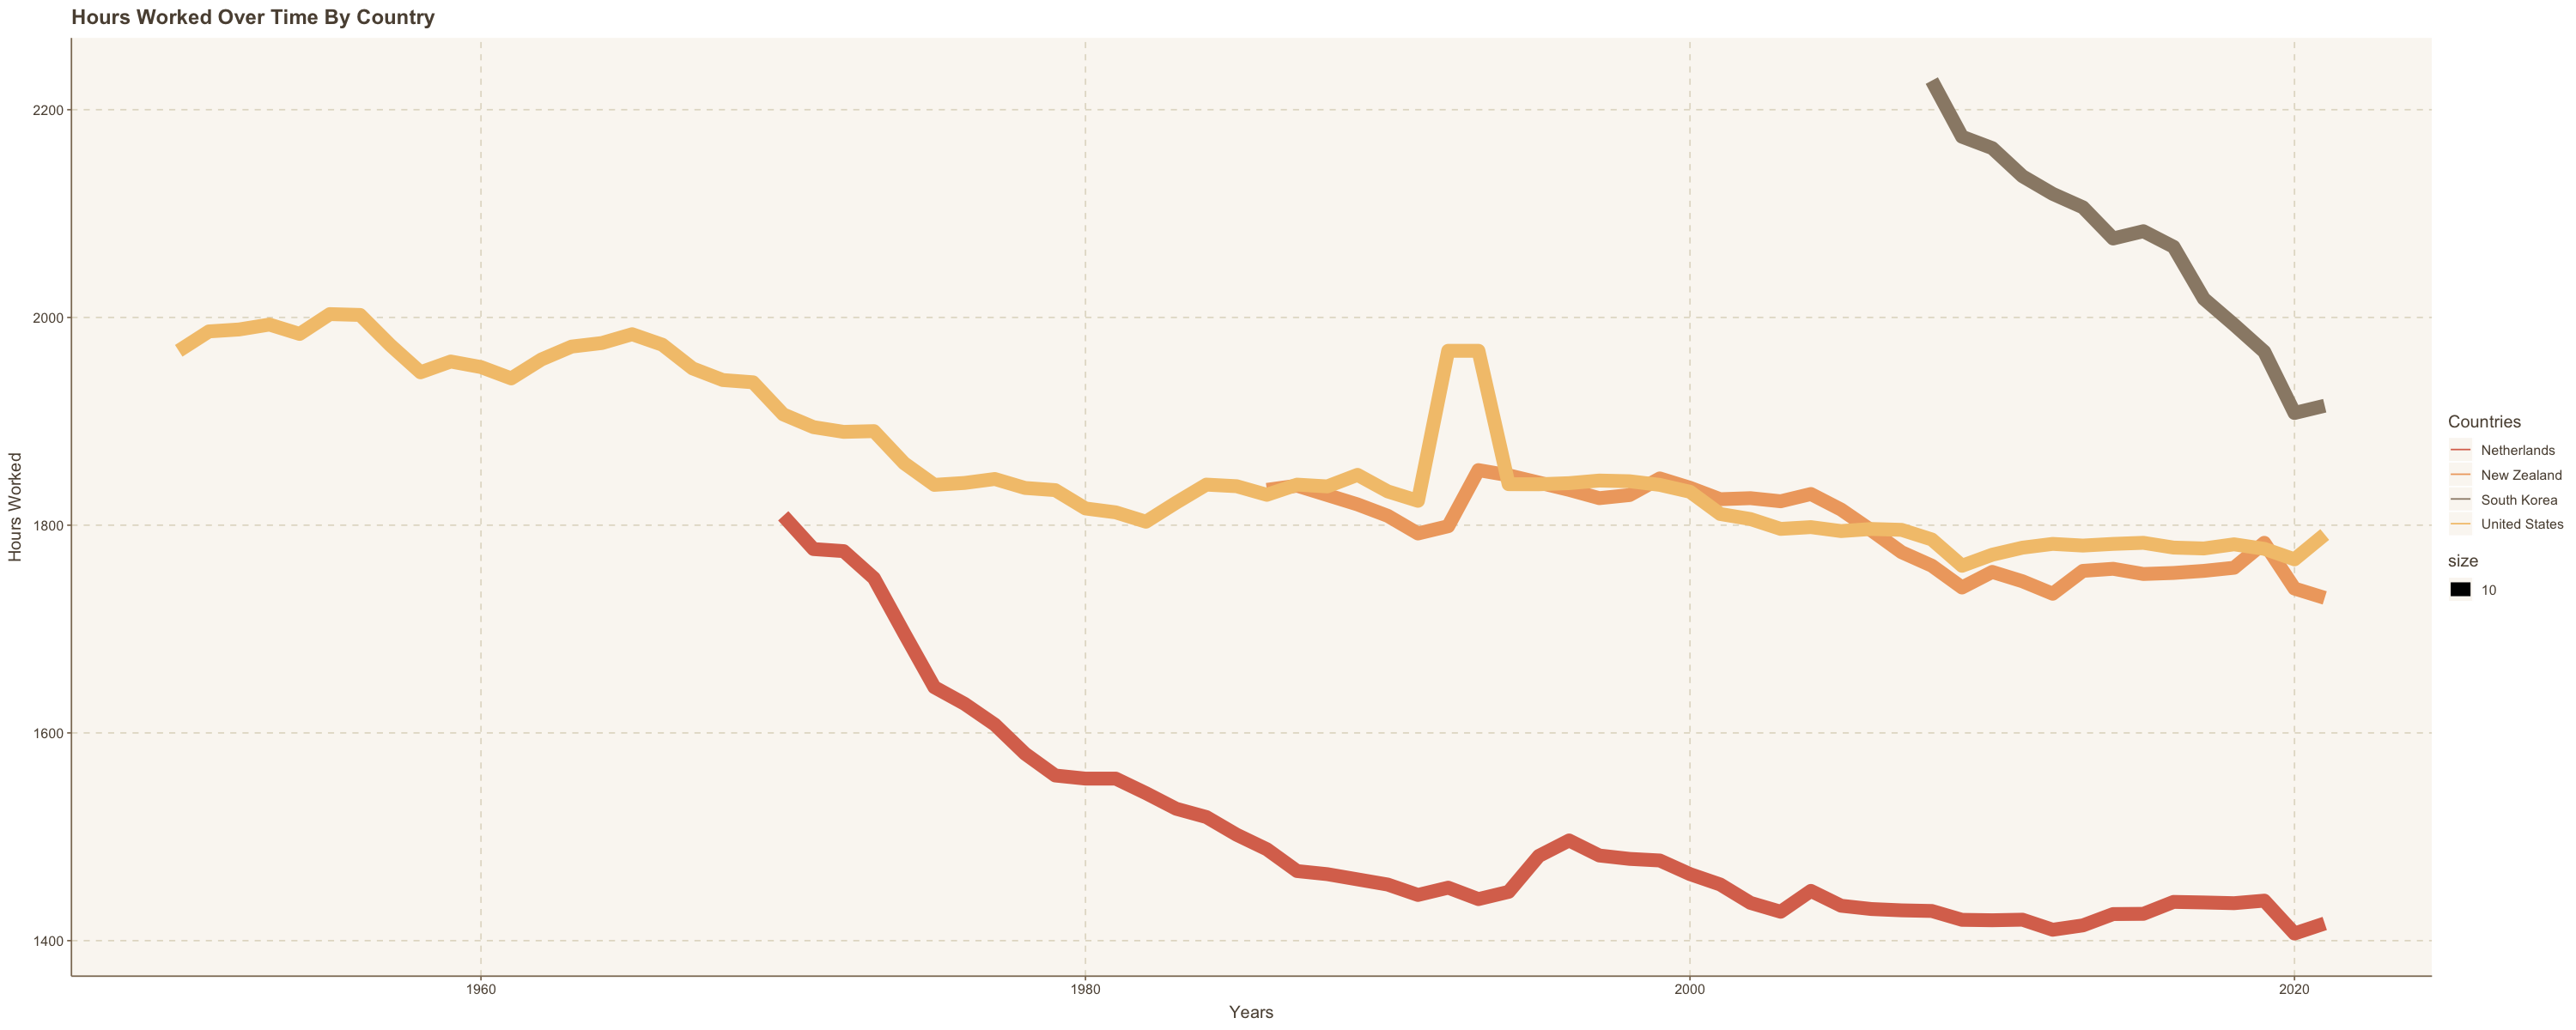

In [17]:
filtered_oecd %>% 
    ggplot(aes(x=Years, y=Hours, col=Countries, size=10)) + 
    geom_freqpoly(stat='identity') + #Creates a barplot and uses stat=identity, to let the y values of Houes be used
    labs(x='Years', y = 'Hours Worked', title = 'Hours Worked Over Time By Country') #labels the graph accurately